In [4]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd

In [97]:
# Rock Island, Moline, Davenport, Bettendorf

In [98]:
# Quad cities bounds

min_lon = -90.6879323
min_lat = 41.4150156
max_lon = -90.4252158
max_lat = 41.6242105

In [99]:
boundaries = gpd.read_feather('./data/quad_cities/boundaries.feather')

In [100]:
def reproject_raster(input_path, reproj_path, dst_crs):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(reproj_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,
                )

    print("Reprojected to 4326:", reproj_path)

In [5]:
def plot_raster(output_path, title):
    with rasterio.open(output_path) as src:
        data = src.read(1)

        # Extract bounds for proper geographic axes
        bounds = src.bounds
        extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

        plt.figure(figsize=(10, 8))

        # Show raster with a geographic extent
        img = plt.imshow(
            data,
            cmap="viridis",
            extent=extent,
            origin="upper"   # important for north-up orientation
        )

        plt.title(title)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

        # Add colorbar
        cbar = plt.colorbar(img)
        cbar.set_label("Value")

        plt.tight_layout()
        plt.show()

In [102]:
def crop_raster_to_boundaries(reproj_path, cropped_path, gdf):

    with rasterio.open(reproj_path) as src:
        print("Raster CRS:", src.crs)
        print("Raster bounds before crop:", src.bounds)

        # Reproject city polygons to match raster CRS if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Get list of geojson-like geometry dicts
        geoms = [mapping(geom) for geom in gdf.geometry]

        # Mask & crop
        out_image, out_transform = mask(
            src,
            geoms,
            crop=True,   # crop to the extent of the geometries
            nodata=src.nodata
        )

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    # Write the cropped raster
    with rasterio.open(cropped_path, "w", **out_meta) as dst:
        dst.write(out_image)

    print("Saved cropped raster to:", cropped_path)

    # Optional sanity check
    with rasterio.open(cropped_path) as r:
        print("Cropped bounds:", r.bounds)
        print("Cropped shape:", r.width, "x", r.height)

In [103]:
def crop_raster_to_bbox(reproj_path, cropped_path, min_lon, min_lat, max_lon, max_lat):
    with rasterio.open(reproj_path) as src:
        # Make sure we're really in 4326
        print("CRS:", src.crs)
        print("Bounds before crop:", src.bounds)

        # Build a window from the bbox in 4326
        window = from_bounds(
            min_lon, min_lat, max_lon, max_lat,
            transform=src.transform
        )

        # Get the new transform for this window
        window_transform = src.window_transform(window)

        # Prepare metadata for cropped raster
        kwargs = src.meta.copy()
        kwargs.update({
            "height": int(window.height),
            "width": int(window.width),
            "transform": window_transform
        })

        with rasterio.open(cropped_path, "w", **kwargs) as dst:
            dst.write(src.read(window=window))

    print("Saved cropped quad-cities raster to:", cropped_path)

    # Optional sanity check
    with rasterio.open(cropped_path) as r:
        print("Cropped bounds:", r.bounds)
        print("Cropped shape:", r.width, "x", r.height)

In [10]:
input_path = "./models/flooding_/NbS_others_5m.tif"
reproj_path = "./models/flooding_/NbS_others_5m_4326.tif"

dst_crs = "EPSG:4326"
reproject_raster(input_path, reproj_path, dst_crs)

Reprojected to 4326: ./data/flooding/NbS_others_5m_4326.tif


In [ ]:
reproj_path = "./models/flooding_/NbS_others_5m_4326.tif"
plot_raster(reproj_path, "4326 + Without cropping: NBS Raster")

In [ ]:
reproj_path = "./models/flooding_/NbS_others_5m_4326.tif"
cropped_path = "./models/flooding_/NBS_others_5m_4326_cropped_quad_cities.tif"
# crop_raster_to_bbox(reproj_path, cropped_path, min_lon, min_lat, max_lon, max_lat)
crop_raster_to_boundaries(reproj_path, cropped_path, boundaries)

In [ ]:
plot_raster(cropped_path, "4326 + Cropped to Quad Cities: NBS Raster")

In [104]:
def clean_NBS_raster(input_path, output_path):
    allowed = {21, 31, 43, 52, 71, 81, 90, 95}

    with rasterio.open(input_path) as src:
        data = src.read(1)  # single-band raster
        profile = src.profile

    # Create a mask for allowed values
    mask_allowed = np.isin(data, list(allowed))

    # Create cleaned array
    cleaned = np.where(mask_allowed, data, 0).astype(profile["dtype"])

    # Save cleaned raster
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(cleaned, 1)

    print("Saved cleaned raster:", output_path)

In [105]:
def resample_NBS_raster_to_flood_grid(
    nbs_raster_path,  # e.g. "./models/flooding/NBS_others_5m_4326_cropped.tif"
    flood_ref_path,   # e.g. "./models/flooding/2020_2040_NbS_4326_cropped.tif"
    output_path       # e.g. "./models/flooding/NBS_others_5m_4326_cropped_resampled.tif"
):
    with rasterio.open(nbs_raster_path) as src_mask, \
         rasterio.open(flood_ref_path) as src_ref:

        # Take target grid from flood raster
        dst_height, dst_width = src_ref.height, src_ref.width

        print("Source (mask) shape:", src_mask.height, src_mask.width)
        print("Target (flood) shape:", dst_height, dst_width)

        # Decide nodata for the uint8 mask
        # Use existing mask nodata if valid, otherwise 0
        mask_dtype = src_mask.dtypes[0]
        nodata = src_mask.nodata

        if nodata is None:
            nodata = 0
        else:
            # Ensure nodata is within dtype range
            info = np.iinfo(mask_dtype)
            if nodata < info.min or nodata > info.max:
                nodata = 0

        # Prepare destination array filled with nodata
        dst_data = np.full((dst_height, dst_width), nodata, dtype=mask_dtype)

        reproject(
            source=rasterio.band(src_mask, 1),
            destination=dst_data,
            src_transform=src_mask.transform,
            src_crs=src_mask.crs,
            dst_transform=src_ref.transform,
            dst_crs=src_ref.crs,
            src_nodata=src_mask.nodata,
            dst_nodata=nodata,
            resampling=Resampling.nearest,   # categorical
        )

        # Build output profile: grid like flood, dtype/nodata like mask
        dst_profile = src_ref.profile.copy()
        dst_profile.update(
            height=dst_height,
            width=dst_width,
            dtype=mask_dtype,
            nodata=nodata,
            count=1,
        )

        with rasterio.open(output_path, "w", **dst_profile) as dst:
            dst.write(dst_data, 1)

    print("Resampled NBS mask written to:", output_path)

In [ ]:
nbs_cropped_4326 = "./models/flooding_/NbS_others_5m_4326_cropped_quad_cities.tif"
nbs_cropped_4326_cleaned = "./models/flooding_/NBS_others_5m_4326_cropped_quad_cities_cleaned.tif"

clean_NBS_raster(nbs_cropped_4326, nbs_cropped_4326_cleaned)

In [ ]:
plot_raster(nbs_cropped_4326_cleaned, "4326 + Cropped to Quad Cities + Cleaned: NBS Raster")

##### Run the cells below to prepare flooding data

In [ ]:
files = ['2020_2040_NbS', '2020_2040_noNbS', '2050_2080_NbS', '2050_2080_noNbS', '2080_2100_NbS', '2080_2100_noNbS', 'NbS_others_5m']

for file in files:
    input_path = f"./models/flooding_/{file}.tif"
    reproj_path = f"./models/flooding_/{file}_4326.tif"

    dst_crs = "EPSG:4326"
    reproject_raster(input_path, reproj_path, dst_crs)

    cropped_path = f"./models/flooding/{file}_4326_cropped.tif"
    crop_raster_to_bbox(reproj_path, cropped_path, min_lon, min_lat, max_lon, max_lat)

In [107]:
nbs_cropped_4326 = "./models/flooding/NbS_others_5m_4326_cropped.tif"
nbs_cropped_4326_cleaned = "./models/flooding/NBS_others_5m_4326_cropped_cleaned.tif"
nbs_cropped_4326_cleaned_resampled = "./models/flooding/NBS_others_5m_4326_cropped_cleaned_resampled.tif"
flood_ref_path = "./models/flooding/2020_2040_NbS_4326_cropped.tif"

clean_NBS_raster(nbs_cropped_4326, nbs_cropped_4326_cleaned)
resample_NBS_raster_to_flood_grid(
    nbs_cropped_4326_cleaned,
    flood_ref_path,
    nbs_cropped_4326_cleaned_resampled
)


Saved cleaned raster: ./models/flooding/NBS_others_5m_4326_cropped_cleaned.tif
Source (mask) shape: 12839 16123
Target (flood) shape: 2064 2592
Resampled NBS mask written to: ./models/flooding/NBS_others_5m_4326_cropped_cleaned_resampled.tif


In [ ]:
# 21: Bioswales/Infiltration trenches
# 31: Permeable pavements
# 43: Retention ponds
# 52: Infiltration trench
# 71, 81: Bioswales
# 90, 95: Constructed wetlands

# create a dict for above:


In [2]:

def combine_flood_nbs_nonbs(
    region,
    output,
    year="2020_2040",
    use_NBS_classes={
        "Bioswales/Infiltration trenches",
        "Permeable pavements",
        "Retention ponds",
        "Infiltration trench",
        "Bioswales",
        "Constructed wetlands",
    },
):
    dict_use_NBS_classes = {
        21: "Bioswales/Infiltration trenches",
        31: "Permeable pavements",
        43: "Retention ponds",
        52: "Infiltration trench",
        71: "Bioswales",
        81: "Bioswales",
        90: "Constructed wetlands",
        95: "Constructed wetlands",
    }

    # Codes where we use NBS flood values
    use_NBS_classes_ = {
        code for code, name in dict_use_NBS_classes.items()
        if name in use_NBS_classes
    }

    mask_path       = "./models/flooding/NBS_others_5m_4326_cropped_cleaned_resampled.tif"
    nbs_flood_path  = f"./models/flooding/{year}_NbS_4326_cropped.tif"
    nonbs_flood_path= f"./models/flooding/{year}_noNbS_4326_cropped.tif"
    output_path     = f"./data/served/raster/{output}.tif"

    with rasterio.open(mask_path) as src_mask, \
         rasterio.open(nbs_flood_path) as src_nbs, \
         rasterio.open(nonbs_flood_path) as src_nonbs:

        # all rasters must be on same grid
        assert src_mask.crs == src_nbs.crs == src_nonbs.crs
        assert src_mask.transform == src_nbs.transform == src_nonbs.transform

        # ---------------------------------------------------------------------
        # 1) Crop by bbox or GeoJSON
        # ---------------------------------------------------------------------
        if isinstance(region, (list, tuple)) and len(region) == 4:
            # region is a bbox: (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat, max_lon, max_lat = region

            window = from_bounds(
                min_lon, min_lat, max_lon, max_lat,
                transform=src_mask.transform,
            )

            mask_data_   = src_mask.read(1, window=window)
            nbs_data_    = src_nbs.read(1, window=window)
            nonbs_data_  = src_nonbs.read(1, window=window)

            out_transform = src_mask.window_transform(window)
            out_height, out_width = mask_data_.shape

        else:
            # region is assumed to be a GeoJSON name (without extension)
            geojson_path = f"./data/boundaries/{region}.geojson"
            gdf = gpd.read_file(geojson_path)

            if gdf.crs != src_mask.crs:
                gdf = gdf.to_crs(src_mask.crs)

            geoms = [mapping(geom) for geom in gdf.geometry]

            # mask returns (bands, rows, cols)
            mask_arr, out_transform = mask(
                src_mask, geoms, crop=True, nodata=src_mask.nodata
            )
            nbs_arr, _ = mask(
                src_nbs, geoms, crop=True, nodata=src_nbs.nodata
            )
            nonbs_arr, _ = mask(
                src_nonbs, geoms, crop=True, nodata=src_nonbs.nodata
            )

            mask_data_  = mask_arr[0]
            nbs_data_   = nbs_arr[0]
            nonbs_data_ = nonbs_arr[0]

            print("Cropped shapes:", mask_data_.shape, nbs_data_.shape, nonbs_data_.shape)

            out_height, out_width = mask_data_.shape

        # ---------------------------------------------------------------------
        # 2) Combine logic: NBS classes vs noNBS
        # ---------------------------------------------------------------------
        cond_use_NBS = np.isin(mask_data_, list(use_NBS_classes_))
        combined = np.where(cond_use_NBS, nbs_data_, nonbs_data_)

        print("Combined flood raster shape:", combined.shape)

        # ---------------------------------------------------------------------
        # 3) Clean up nodata: replace huge negative with 0
        # ---------------------------------------------------------------------
        flood_nodata = src_nbs.nodata  # typically -1.797e308

        if flood_nodata is not None:
            # Turn that nodata sentinel into 0 so web client can treat 0 as "no flood"
            combined = np.where(combined == flood_nodata, np.nan, combined)

        # ---------------------------------------------------------------------
        # 4) Build output profile
        # ---------------------------------------------------------------------
        profile = src_nbs.profile.copy()
        profile.update(
            dtype=combined.dtype,
            height=out_height,
            width=out_width,
            transform=out_transform,
            nodata=0.0,  # we now treat 0 as nodata / no flood
        )

    # -------------------------------------------------------------------------
    # 5) Write output raster
    # -------------------------------------------------------------------------
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(combined, 1)

    print("Saved combined flood raster to:", output_path)

In [66]:
bbox = (-90.48, -90.42, 41.41, 41.50)

combined = combine_flood_nbs_nonbs(
    'davenport',
    "scenario_1",
    year = "2020_2040",
    use_NBS_classes={}
)

Cropped shapes: (1615, 1946) (1615, 1946) (1615, 1946)
Combined flood raster shape: (1615, 1946)
Saved combined flood raster to: ./data/served/raster/scenario_1.tif


In [8]:
with rasterio.open("./data/served/raster/flood-scenario-1.tif") as r:
    print("Bounds:", r.bounds)
    print("Shape:", r.height, r.width)

Bounds: BoundingBox(left=-90.53278166253892, bottom=41.52104698012057, right=-90.42526054800841, top=41.61215111015161)
Shape: 899 1061


In [12]:
from flood_simulation import simulate_flood_projection


simulate_flood_projection(
    (-90.6879323, 41.4150156, -90.60, 41.525),
    "B",
    year="2020 - 2040",
    use_NBS_classes= [
        # "Bioswales/Infiltration trenches",
        # "Permeable pavements",
        # "Retention ponds",
        # "Infiltration trench",
        "Bioswales",
        "Constructed wetlands",
    ],
)

Combined flood raster shape: (1085, 868)
Saved combined flood raster to: ./data/served/raster/B.tif


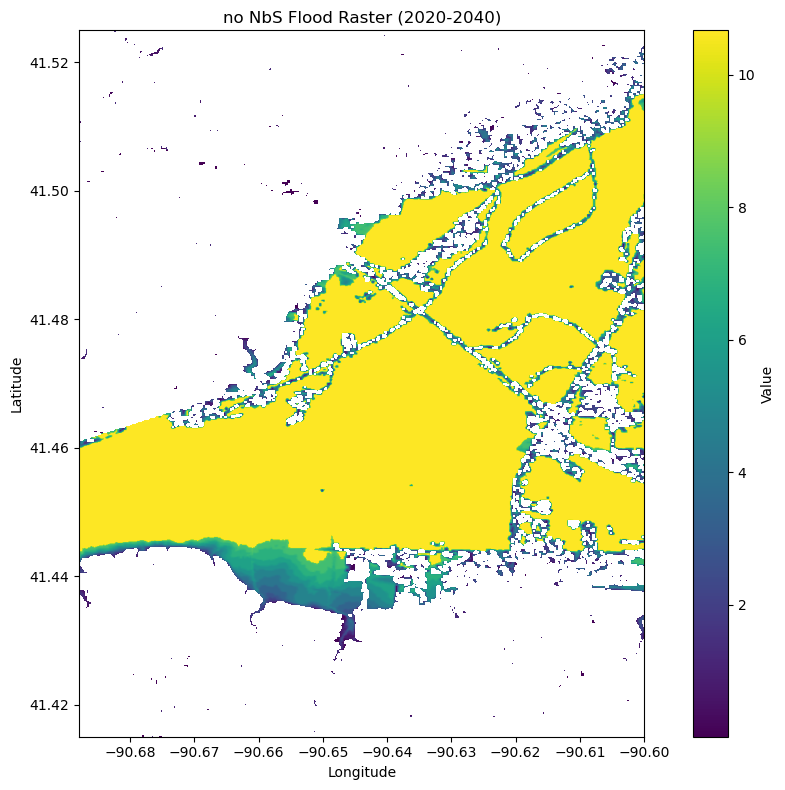

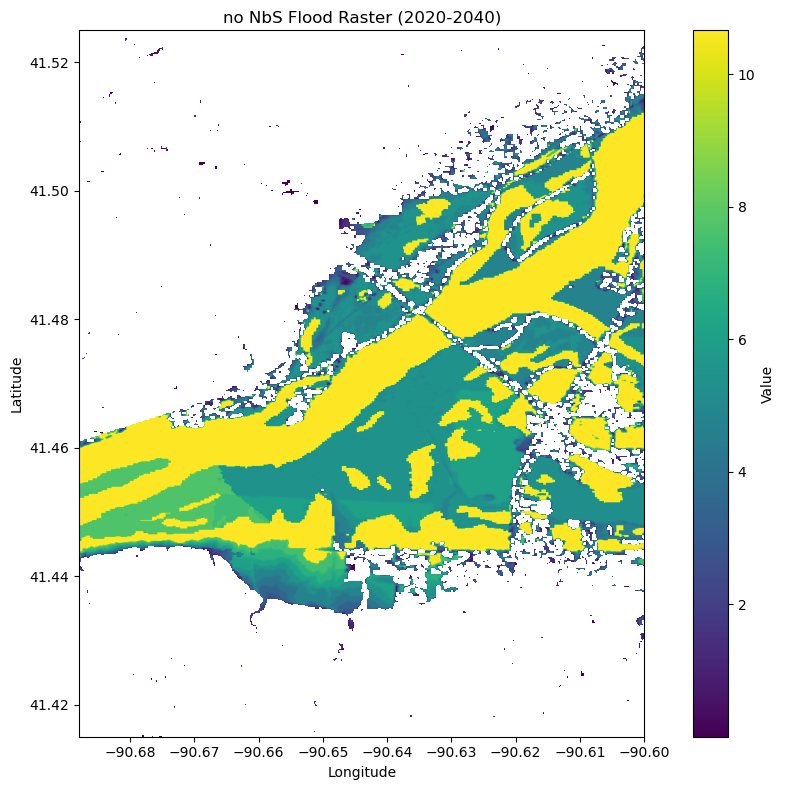

In [53]:
plot_raster("./data/served/raster/flood-scenario-2.tif", "no NbS Flood Raster (2020-2040)")
plot_raster("./data/served/raster/flood-scenario-1.tif", "no NbS Flood Raster (2020-2040)")

In [4]:
import rasterio
path1 = "./data/served/raster/flood-scenario-1.tif"
path2 = "./data/served/raster/flood-scenario-2.tif"
out_path = "./data/served/raster/flood-scenario-diff.tif"

with rasterio.open(path1) as r1, rasterio.open(path2) as r2:
    arr1 = r1.read(1).astype("float32")
    arr2 = r2.read(1).astype("float32")

    # Difference (scenario2 - scenario1)
    diff = arr2 - arr1

    # Prepare output profile
    profile = r1.profile
    profile.update(
        dtype="float32",
        count=1
    )

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(diff, 1)

print("Saved difference:", out_path)

Saved difference: ./data/served/raster/flood-scenario-diff.tif


In [46]:
import rasterio
import geopandas as gpd
from rasterio import features
import numpy as np

tif_path = "./data/served/raster/flood-scenario-1.tif"

with rasterio.open(tif_path) as src:
    arr = src.read(1)  # read band 1
    transform = src.transform
    profile = src.profile

shapes = [(geom, 1) for geom in gdf.geometry if not geom.is_empty]

mask = features.rasterize(
    shapes=shapes,
    out_shape=arr.shape,
    transform=transform,
    fill=0,           # outside polygons
    default_value=1,  # inside polygons
    dtype="uint8"
)

In [47]:
# Make sure we can store NaNs
arr = arr.astype("float32")

# Set all pixels inside polygons to NaN
arr[mask == 1] = np.nan

In [48]:
avg_val = np.nanmean(arr)
print(avg_val)

7.161058


In [61]:
import rasterio
import numpy as np

tif_path = "./data/served/raster/flood-scenario-2.tif"

with rasterio.open(tif_path) as src:
    arr = src.read(1)  # read band 1
    print("Shape:", arr.shape)
    print("Min:", np.nanmin(arr))
    print("Max:", np.nanmax(arr))
    print("Unique values:", np.unique(arr))  # first 20 unique values

nan_count = np.isnan(arr).sum()
print("NaN count:", nan_count)

valid_count = np.sum(~np.isnan(arr))
print("Valid count:", valid_count)

median_val = np.nanmedian(arr)
print(median_val)

stddev_val = np.nanstd(arr)
print(stddev_val)

Shape: (1085, 868)
Min: 0.005472819010416667
Max: 10.666666666666666
Unique values: [5.47281901e-03 5.49316406e-03 8.95182292e-03 ... 7.99730428e+00
 1.06666667e+01            nan]
NaN count: 523437
Valid count: 418343
10.666666666666666
3.499924248045202


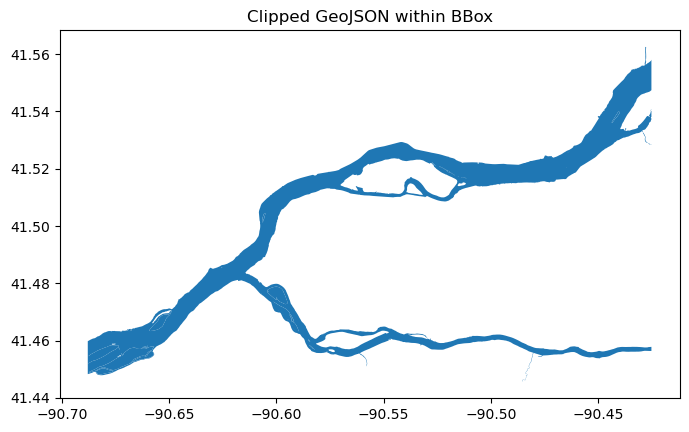

In [40]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# --- 1. Read your GeoJSON ---
gdf = gpd.read_file("./models/flooding_/waterways.geojson")  # change filename as needed
gdf = gdf[~gdf.geometry.geom_type.isin(["Point", "MultiPoint"])]
gdf = gdf['geometry']
# If it's not already in WGS84 (EPSG:4326), uncomment and set correct CRS:
# gdf = gdf.to_crs(epsg=4326)

# --- 2. Define your bounding box (lon, lat) ---
min_lon = -90.6879323
min_lat = 41.4150156
max_lon = -90.4252158
max_lat = 41.6242105

bbox_geom = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox_geom])

# --- 3. Strict crop (clip geometries to bbox) ---
gdf_clipped = gpd.clip(gdf, bbox_gdf)

# --- 4. Plot result ---
fig, ax = plt.subplots(figsize=(8, 8))
gdf_clipped.plot(ax=ax)
# bbox_gdf.boundary.plot(ax=ax, linewidth=1)  # optional: show bbox outline
ax.set_title("Clipped GeoJSON within BBox")
plt.show()

In [41]:
gdf

0      POLYGON ((-90.60679 41.47639, -90.60630 41.476...
1      POLYGON ((-90.33725 41.65208, -90.33706 41.652...
2      POLYGON ((-90.26211 41.52265, -90.26255 41.522...
3      POLYGON ((-90.42532 41.52845, -90.42528 41.528...
4      POLYGON ((-90.48043 41.45570, -90.48043 41.455...
                             ...                        
103    LINESTRING (-90.57412 41.45552, -90.57444 41.4...
104    LINESTRING (-90.57369 41.45550, -90.57412 41.4...
105    LINESTRING (-90.57627 41.45623, -90.57634 41.4...
106    LINESTRING (-90.60201 41.47363, -90.60221 41.4...
107    LINESTRING (-90.60679 41.47639, -90.60700 41.4...
Name: geometry, Length: 108, dtype: geometry